In [ ]:
!pip install tensorflow
import math
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from keras import callbacks
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from tensorflow.python import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

np.random.seed(0)

2023-05-10 17:46:03.095645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wthr =  pd.read_csv("/content/drive/MyDrive/cse438/Project/weatherAUS2.csv")
wthr.head(200)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


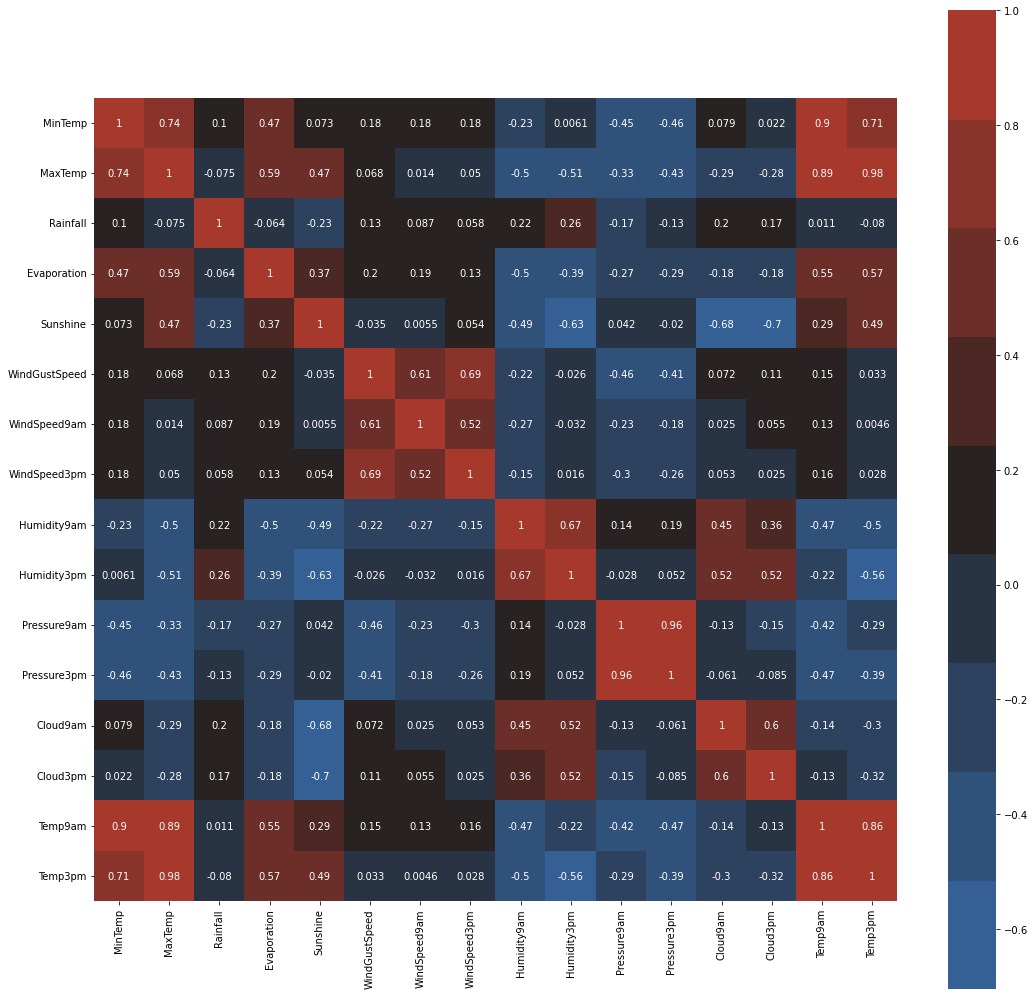

In [ ]:
#Correlation matrix
corr_matrix = wthr.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40,n=9, center="dark")
plt.subplots(figsize=(18,18))
sns.heatmap(corr_matrix,cmap= cmap,annot=True, square=True)

In [ ]:
#Parsing datetime and exploring the length of date objects
len = wthr["Date"].str.len()
len.value_counts()

10    145460
Name: Date, dtype: int64

In [ ]:
#There is no error in dates so parsing values into datetime
wthr['Date']= pd.to_datetime(wthr["Date"])

#Creating a column of year
wthr['year'] = wthr.Date.dt.year

# function to encode datetime into cyclic parameters.

def encode(wthr, col, max_val):
    wthr[col + '_sin'] = np.sin(2 * np.pi * wthr[col]/max_val)
    wthr[col + '_cos'] = np.cos(2 * np.pi * wthr[col]/max_val)
    return wthr

wthr['month'] = wthr.Date.dt.month
wthr = encode(wthr, 'month', 12)

wthr['day'] = wthr.Date.dt.day
wthr = encode(wthr, 'day', 31)

wthr.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Sine Encoded Months')

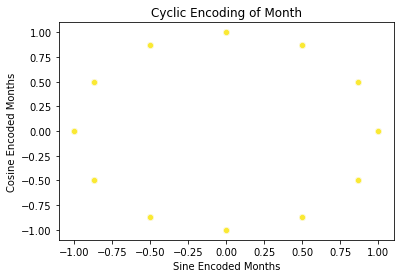

In [ ]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data= wthr, color="#fae934")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

In [ ]:
# Getting list of categorical variables
s = (wthr.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [ ]:
# Missing values in categorical variables
for i in object_cols:
    print(i, wthr[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [ ]:
# Filling missing values with mode of the column in value
for i in object_cols:
    wthr[i].fillna(wthr[i].mode()[0], inplace=True)

In [ ]:
# Get list of neumeric variables
str_num = (wthr.dtypes == "float64")
num_cols = list(str_num[str_num].index)

print("Neumeric variables:")
print(num_cols)

Neumeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [ ]:
# Missing values in numeric variables
for i in num_cols:
    print(i, wthr[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [ ]:
# Filling missing values with median of the column in value
for i in num_cols:
    wthr[i].fillna(wthr[i].median(), inplace=True)

wthr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [ ]:
label_encoder = LabelEncoder()

for i in object_cols:
    wthr[i] = label_encoder.fit_transform(wthr[i])

#wthr.head()

In [ ]:
# Prepairing attributes of scale data

feature_col = wthr.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping tget and extra columns

tget = wthr['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(feature_col.columns)
s_scaler = preprocessing.StandardScaler()
feature_col = s_scaler.fit_transform(feature_col)
feature_col = pd.DataFrame(feature_col, columns=col_names)

#feature_col.describe().T

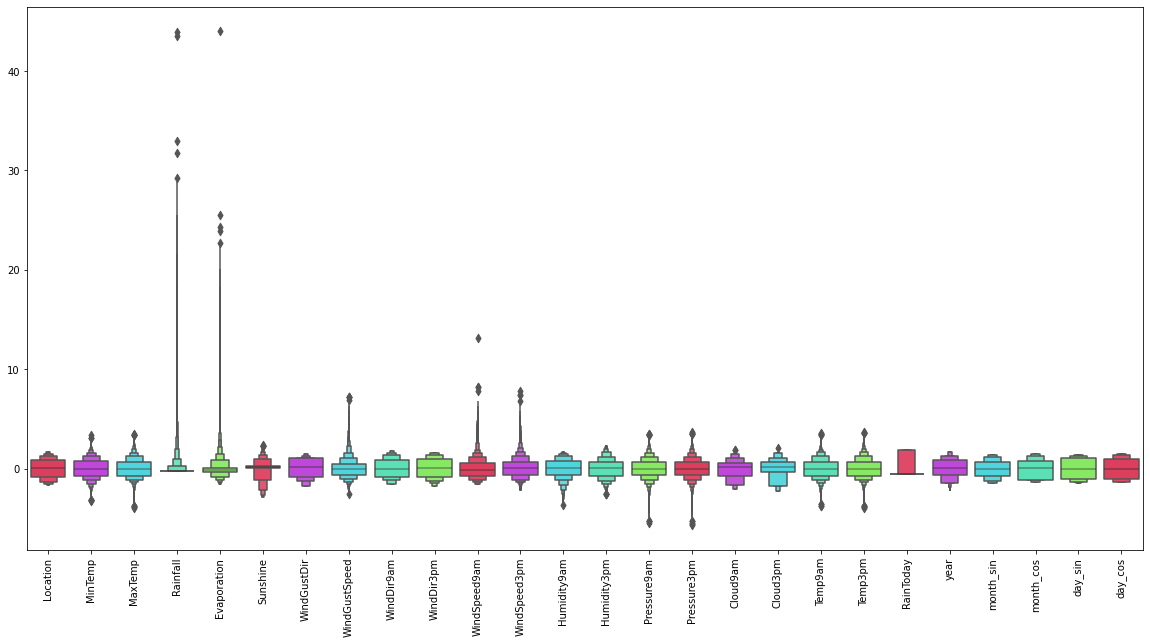

In [ ]:
#Detecting outliers
colours = ["#f7234d", "#cf30f2", "#38e9f2", "#45f5bd", "#7cff4d"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = feature_col,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#full data for
feature_col["RainTomorrow"] = tget

#Dropping with outlier

feature_col = feature_col[(feature_col["MinTemp"]<2.3)&(feature_col["MinTemp"]>-2.3)]
feature_col = feature_col[(feature_col["MaxTemp"]<2.3)&(feature_col["MaxTemp"]>-2)]
feature_col = feature_col[(feature_col["Rainfall"]<4.5)]
feature_col = feature_col[(feature_col["Evaporation"]<2.8)]
feature_col = feature_col[(feature_col["Sunshine"]<2.1)]
feature_col = feature_col[(feature_col["WindGustSpeed"]<4)&(feature_col["WindGustSpeed"]>-4)]
feature_col = feature_col[(feature_col["WindSpeed9am"]<4)]
feature_col = feature_col[(feature_col["WindSpeed3pm"]<2.5)]
feature_col = feature_col[(feature_col["Humidity9am"]>-3)]
feature_col = feature_col[(feature_col["Humidity3pm"]>-2.2)]
feature_col = feature_col[(feature_col["Pressure9am"]< 2)&(feature_col["Pressure9am"]>-2.7)]
feature_col = feature_col[(feature_col["Pressure3pm"]< 2)&(feature_col["Pressure3pm"]>-2.7)]
feature_col = feature_col[(feature_col["Cloud9am"]<1.8)]
feature_col = feature_col[(feature_col["Cloud3pm"]<2)]
feature_col = feature_col[(feature_col["Temp9am"]<2.3)&(feature_col["Temp9am"]>-2)]
feature_col = feature_col[(feature_col["Temp3pm"]<2.3)&(feature_col["Temp3pm"]>-2)]


feature_col.shape

(127536, 27)

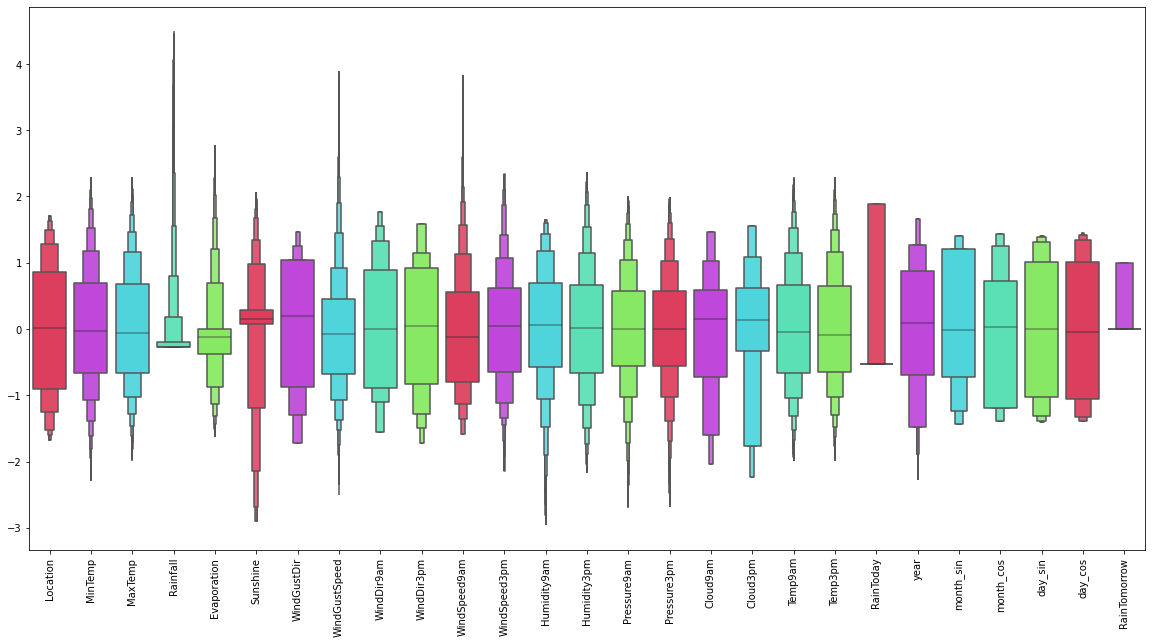

In [ ]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = feature_col,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [ ]:
X = feature_col.drop(["RainTomorrow"], axis=1)
y = feature_col["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

In [ ]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
# Initialising the NN
model = Sequential()

In [ ]:
# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [ ]:
# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 5, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/5
2551/2551 [==============================] - 15s 5ms/step - loss: 0.4819 - accuracy: 0.7841 - val_loss: 0.3934 - val_accuracy: 0.7860
Epoch 2/5
2551/2551 [==============================] - 17s 7ms/step - loss: 0.4194 - accuracy: 0.7842 - val_loss: 0.3883 - val_accuracy: 0.7860
Epoch 3/5
2551/2551 [==============================] - 7s 3ms/step - loss: 0.4177 - accuracy: 0.7842 - val_loss: 0.3859 - val_accuracy: 0.7860
Epoch 4/5
2551/2551 [==============================] - 7s 3ms/step - loss: 0.4144 - accuracy: 0.7842 - val_loss: 0.3846 - val_accuracy: 0.7860
Epoch 5/5
2551/2551 [==============================] - 7s 3ms/step - loss: 0.4125 - accuracy: 0.7842 - val_loss: 0.3838 - val_accuracy: 0.7860


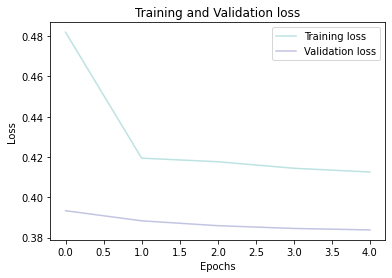

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

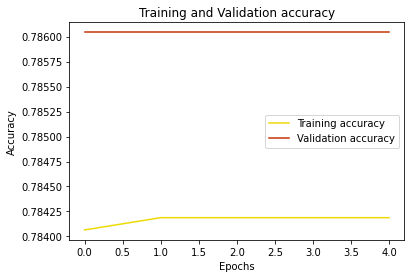

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#edda05", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#c23202", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Classification Report

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

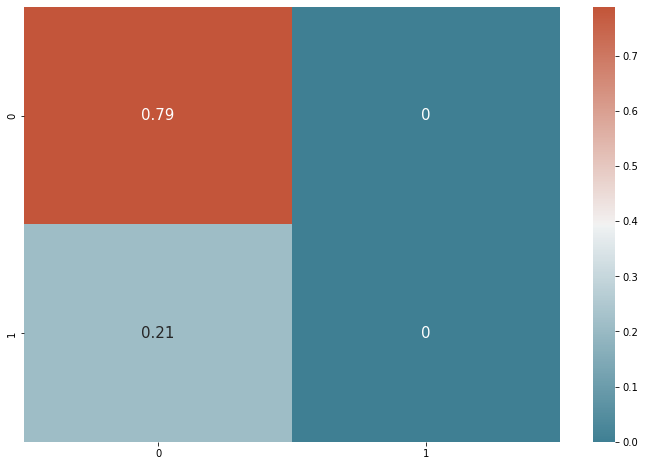

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(220, 20, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     20110
           1       0.00      0.00      0.00      5398

    accuracy                           0.79     25508
   macro avg       0.39      0.50      0.44     25508
weighted avg       0.62      0.79      0.70     25508



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# And we need to replace NaN values with mean values of each column:
wthr.fillna(wthr.mean(), inplace=True)
wthr.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,2,13.4,22.9,0.6,4.8,8.4,13,44.0,13,...,21.8,0,0,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,2,7.4,25.1,0.0,4.8,8.4,14,44.0,6,...,24.3,0,0,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,2,12.9,25.7,0.0,4.8,8.4,15,46.0,13,...,23.2,0,0,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,2,9.2,28.0,0.0,4.8,8.4,4,24.0,9,...,26.5,0,0,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,2,17.5,32.3,1.0,4.8,8.4,13,41.0,1,...,29.7,0,0,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


In [ ]:
wthr['Evaporation'] = wthr['Evaporation'].astype(int)
wthr['WindDir9am'] = wthr['WindDir9am'].astype(int)
wthr['WindDir3pm'] = wthr['WindDir3pm'].astype(int)
wthr['Humidity9am'] = wthr['Humidity9am'].astype(int)
wthr['Pressure9am'] = wthr['Pressure9am'].astype(int)
wthr['WindGustSpeed'] = wthr['WindGustSpeed'].astype(int)
wthr.dtypes

Date             datetime64[ns]
Location                  int64
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation               int64
Sunshine                float64
WindGustDir               int64
WindGustSpeed             int64
WindDir9am                int64
WindDir3pm                int64
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am               int64
Humidity3pm             float64
Pressure9am               int64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                 int64
RainTomorrow              int64
year                      int64
month                     int64
month_sin               float64
month_cos               float64
day                       int64
day_sin                 float64
day_cos                 float64
dtype: object

In [ ]:
feature_cols = ['WindGustSpeed','WindDir9am','WindDir3pm','Pressure9am','Humidity3pm', 'Humidity9am','Evaporation']
X = wthr[feature_cols] # Features
y = wthr.RainTomorrow # Target variable

In [ ]:
#Splitting data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [ ]:
y_pred=logmodel.predict(X_test)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[21634,  1092],
       [ 3735,  2631]])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     22726
           1       0.71      0.41      0.52      6366

    accuracy                           0.83     29092
   macro avg       0.78      0.68      0.71     29092
weighted avg       0.82      0.83      0.82     29092

